In [ ]:
import os
import random
import math
import gc

import cv2
import imutils
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf

import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, KFold


In [2]:
working_dir = "/home/guru/Documents/Vision/Kaggle/Plant-Pathalogy2020"
image_dir= "/home/guru/Documents/Vision/Kaggle/Plant-Pathalogy2020/images"

train_df= pd.read_csv(working_dir+"/train.csv")
test_df= pd.read_csv(working_dir+"/test.csv")
sample_df= pd.read_csv(working_dir+"/sample_submission.csv")

In [3]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


#### Training data has class labels presented as one-hot vectors.

In [4]:
train_df.duplicated().sum()

0

In [5]:
sample_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


#### From the sample submission format, we have to predict the probabilities of the classes corresponding to the test images.

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


### Helper Functions

In [35]:
#function to load image

def load_image(image_id):
    file= image_id+".jpg" #since all the files have jpg format
    image= cv2.imread(os.path.join(image_dir,file))
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

#function to show images
def show_image(image_id, figsize= (70,7)):
    plt.figure(figsize = figsize)
    plt.imshow(mpimg.imread(f'/home/guru/Documents/Vision/Kaggle/Plant-Pathalogy2020/images/{image_id}.jpg'))
    plt.grid(False)
    plt.show()
    
#function to display sample images
def plot_images(image_ids, size=4, figsize=(12, 12)):
    #image_ids = train_df['image_id'].unique()[:12]
    images=[]
    
    for image in image_ids:
        images.append(mpimg.imread(f'/home/guru/Documents/Vision/Kaggle/Plant-Pathalogy2020/images/{image}.jpg'))
    
    # Plot images in groups of 4 images
    n_groups = 4
    
    count = 0
    for index in range(size // 4):
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)
        for row in ax:
            for col in row:
                col.imshow(images[count])
                col.axis('off')
                count += 1
        plt.show()
    gc.collect()
    

#funtion to resize image
def resize_(image, width):
    
    resized= imutils.resize(image, width= width)
    return resized


In [8]:
# Load all the training images for analysis
sample_size= 100

train_images= train_df['image_id'][:sample_size].apply(load_image)
print(train_images.shape)

(100,)


#### Healthy leaves

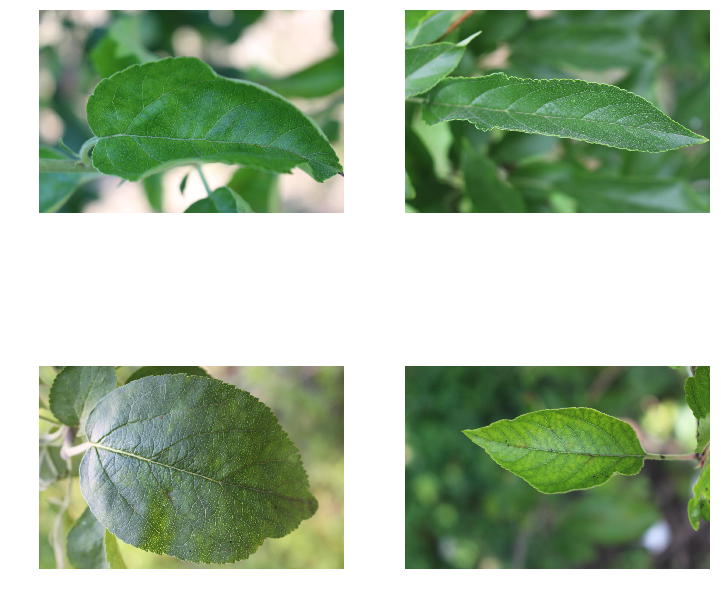

In [26]:
healthy= train_df[train_df['healthy']==1]['image_id'][:8]
plot_images(healthy)

### Scab

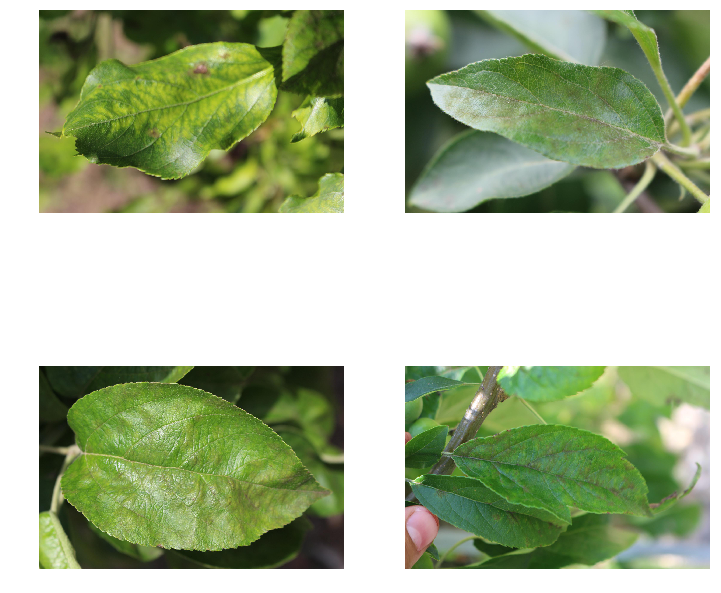

In [27]:
scab= train_df[train_df['scab']==1]['image_id'][:8]
plot_images(scab)

### Rust

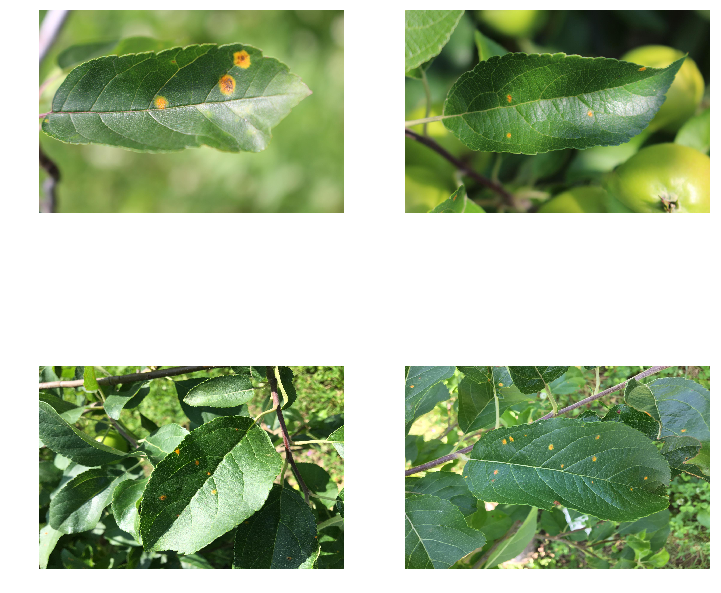

In [28]:
rust= train_df[train_df['rust']==1]['image_id'][:8]
plot_images(rust)

### Multiple Diseases

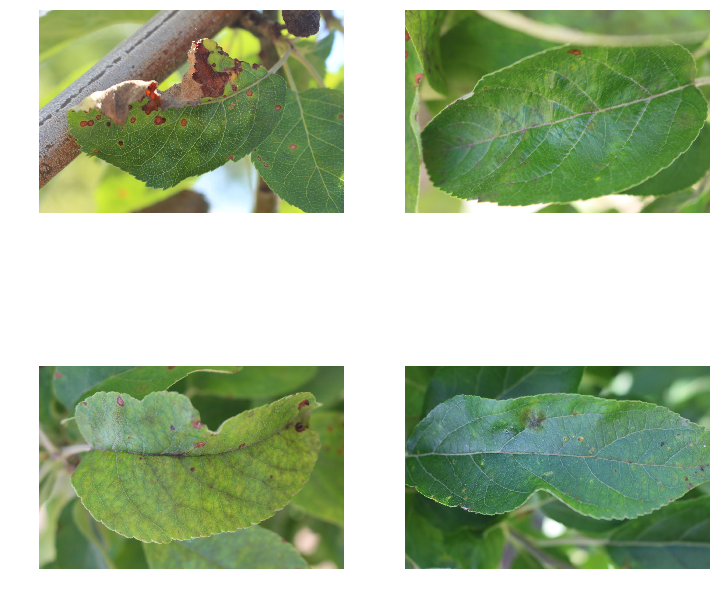

In [30]:
multiple= train_df[train_df['multiple_diseases']==1]['image_id'][:8]
plot_images(multiple)

### Distribution of labels

In [57]:
fig = go.Figure([go.Pie(labels=train_df.columns[1:],
           values=train_df.iloc[:, 1:].sum().values)])
fig.update_layout(title_text="Distribution of labels")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

#### All 3 categories except multiple diseases are fairly uniform

## Channel Statistics

In [25]:
#Let's see the channel distributions(mean values of RGB channels) in all the images and see the variation 

red_values= [np.mean(train_images[i][:,:,0]) for i in range(len(train_images))]

green_values= [np.mean(train_images[i][:,:,1]) for i in range(len(train_images))]

blue_values= [np.mean(train_images[i][:,:,2]) for i in range(len(train_images))]

all_values= [np.mean(train_images[i]) for i in range(len(train_images))]


/home/guru/.virtualenvs/gurus/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



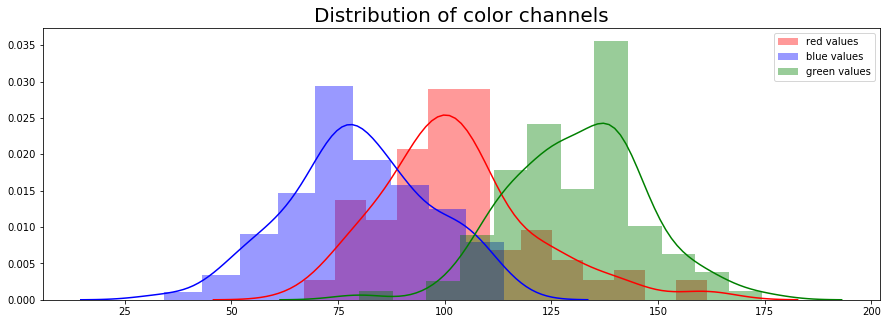

In [27]:
fig= plt.figure(figsize= (15,5))
sns.distplot(red_values, color= "red", label= "red values")
sns.distplot(blue_values, color= "blue", label= "blue values")
sns.distplot(green_values, color= "green", label= "green values")
plt.title("Distribution of color channels", size= 20)
plt.legend()
plt.show()

#### Each channel seems to have it's own separate distribution.

### Inferences:

1. All the images have equal size.
2. Size of the dataset is small.
3. Distribution of labels is rougly uniform except multiple disease label.
4. Distribution of channels can be leveraged for the classification since distribution of each channel is different.
5. There are no duplicate entries.
6. Test labels have probabilities as outputs.
